## Bijector Example
### from https://romainlhardy.medium.com/building-custom-bijectors-with-tensorflow-probability-22241cb6a691

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

In [2]:
class Rotation2D(tfb.Bijector):
  def __init__(self, theta, validate_args=False, name="rotation_2d"):
    super(Rotation2D, self).__init__(
      validate_args=validate_args,
      forward_min_event_ndims=1,
      inverse_min_event_ndims=1,
      name=name,
      is_constant_jacobian=True
    )
    
    self.cos_theta = tf.math.cos(theta)
    self.sin_theta = tf.math.sin(theta)
    self.event_ndim = 1
  
  def _forward(self, x):
    batch_ndim = len(x.shape) - self.event_ndim
    x0 = tf.expand_dims(x[..., 0], batch_ndim)
    x1 = tf.expand_dims(x[..., 1], batch_ndim)
    y0 = self.cos_theta * x0 - self.sin_theta * x1
    y1 = self.sin_theta * x0 + self.cos_theta * x1
    return tf.concat((y0, y1), axis=-1)

  def _inverse(self, y):
    batch_ndim = len(y.shape) - self.event_ndim
    y0 = tf.expand_dims(y[..., 0], batch_ndim)
    y1 = tf.expand_dims(y[..., 1], batch_ndim)
    x0 = self.cos_theta * y0 + self.sin_theta * y1
    x1 = -self.sin_theta * y0 + self.cos_theta * y1
    return tf.concat((x0, x1), axis=-1)

  def _forward_log_det_jacobian(self, x):
    return tf.constant(0., x.dtype)

In [6]:
bijectors = [
  tfb.Scale(log_scale=tf.random.normal((2,))),
  tfb.Shift(shift=tf.random.normal((2,))),
  Rotation2D(theta=tf.random.uniform((), minval=0., maxval=2. * np.pi)),
  tfb.Log()
]

full_bijector = tfb.Chain(list(reversed(bijectors)))

base_distribution = tfd.MultivariateNormalDiag(tf.zeros((2,)), tf.ones((2,)))

transformed_distribution = tfd.TransformedDistribution(
    base_distribution,
    full_bijector
)

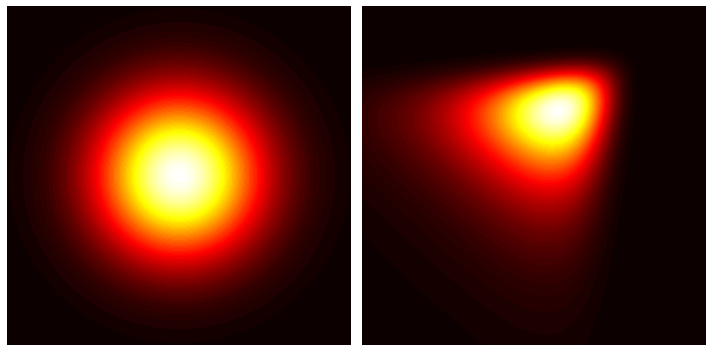

In [7]:
X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
inputs = np.transpose(np.stack((X, Y)), [2, 1, 0])
Z_0 = base_distribution.prob(inputs).numpy()
Z_1 = transformed_distribution.prob(inputs).numpy()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].contourf(X, Y, Z_0, cmap="hot", levels=100)
ax[0].axis("off")
ax[1].contourf(X, Y, Z_1, cmap="hot", levels=100)
ax[1].axis("off")
plt.tight_layout()
plt.show()